<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/ProDiMES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [104]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

##Read data

In [105]:
filename = 'data.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

In [106]:
data = loadmat(file_path)

efs_output_c = data['efs_output_c']
efs_output_to = data['efs_output_to']
engine_params = data['engine_params']
fault_params = data['fault_params']
sensor_noise = data['sensor_noise']

In [107]:
engines, flights, variables = efs_output_c.shape

efs_output_c_flat = efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, efs_output_c_flat))
efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [108]:
efs_output_c_df.head()

,engine,flight,Nf_c,Nc_c,P24_c,Ps30_c,T24_c,T30_c,T48_c,Wf_c,P2_c,T2_c,Pamb_c
0,1.0,1.0,1859.716105,7736.162261,7.783564,108.478553,504.845637,1182.805960,1474.221666,1.096138,4.996488,437.165278,3.258332
1,1.0,2.0,1891.245235,7773.317304,7.817907,111.778643,505.870212,1193.186227,1497.012191,1.147603,4.911140,435.183261,3.239519
2,1.0,3.0,1820.760788,7679.409107,7.798091,106.871041,499.973305,1166.952952,1446.503193,1.061947,5.123497,436.093255,3.461750
3,1.0,4.0,1832.884820,7754.119278,7.779949,105.783964,510.823632,1188.503681,1473.115883,1.062694,5.138640,446.293567,3.463196
4,1.0,5.0,1926.595177,7850.337092,7.612744,110.654180,513.329861,1215.781191,1535.579586,1.161507,4.705399,439.403107,3.134937


In [109]:
engines, flights, variables = efs_output_to.shape

efs_output_to_flat = efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, efs_output_to_flat))
efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [110]:
efs_output_to_df.head()

,engine,flight,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,1.0,1.0,2356.177851,9104.427641,26.942621,465.683562,660.089627,1610.886287,2142.652896,6.328079,14.531178,540.169802,14.060261
1,1.0,2.0,2357.602364,9109.068684,27.486037,474.942210,660.883773,1612.460794,2144.472161,6.456309,14.823973,540.823158,14.329544
2,1.0,3.0,2344.155233,9203.386033,26.326444,445.096894,679.273353,1642.320238,2174.999830,6.084276,14.683170,561.773030,14.227578
3,1.0,4.0,2330.379983,9005.482663,27.424820,474.382898,645.738223,1579.570756,2097.148409,6.346980,14.790438,528.405885,14.333610
4,1.0,5.0,2387.125432,9163.205017,27.400739,477.203053,667.029353,1629.738877,2174.998746,6.566884,14.576603,543.503022,14.054739


In [111]:
engines, flights, params = engine_params.shape

engine_params_flat = engine_params.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, engine_params_flat))
engine_params_df = pd.DataFrame(data, columns=engine_params_columns)

In [112]:
engine_params_df.head()

,engine,flight,altitude_to,mach_to,dTamb_to,NfR_to,altitude_c,mach_c,dTamb_c,Fn_c,fan_eff,fan_fc,lpc_eff,lpc_fc,hpc_eff,hpc_fc,hpt_eff,hpt_fc,lpt_eff,lpt_fc
0,1.0,1.0,1218.615450,0.227200,20.325876,2356.177851,36243.083686,0.807986,-3.292565,6133.589043,-0.941005,-1.252777,-0.138124,-0.322972,-2.006883,-2.632451,-0.851225,0.780203,-0.212728,-0.091244
1,1.0,2.0,697.101966,0.230286,18.963180,2357.602364,36363.562385,0.796491,-3.785644,6660.424508,-0.941396,-1.253348,-0.138319,-0.323552,-2.007238,-2.633175,-0.851514,0.780438,-0.212779,-0.091215
2,1.0,3.0,893.636973,0.222631,40.775749,2485.244954,34977.498404,0.771923,-4.277948,5962.298044,-0.941787,-1.253920,-0.138514,-0.324132,-2.007593,-2.633900,-0.851803,0.780673,-0.212830,-0.091186
3,1.0,4.0,689.289019,0.222157,7.029209,2330.379983,34968.716788,0.774543,4.516337,5825.850264,-0.942178,-1.254492,-0.138709,-0.324712,-2.007948,-2.634625,-0.852091,0.780909,-0.212881,-0.091158
4,1.0,5.0,1229.393386,0.238105,23.123642,2444.498300,37046.316781,0.786355,1.072501,6843.016609,-0.942570,-1.255063,-0.138904,-0.325291,-2.008303,-2.635351,-0.852380,0.781144,-0.212932,-0.091129


In [113]:
fault_params_df = pd.DataFrame(fault_params, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

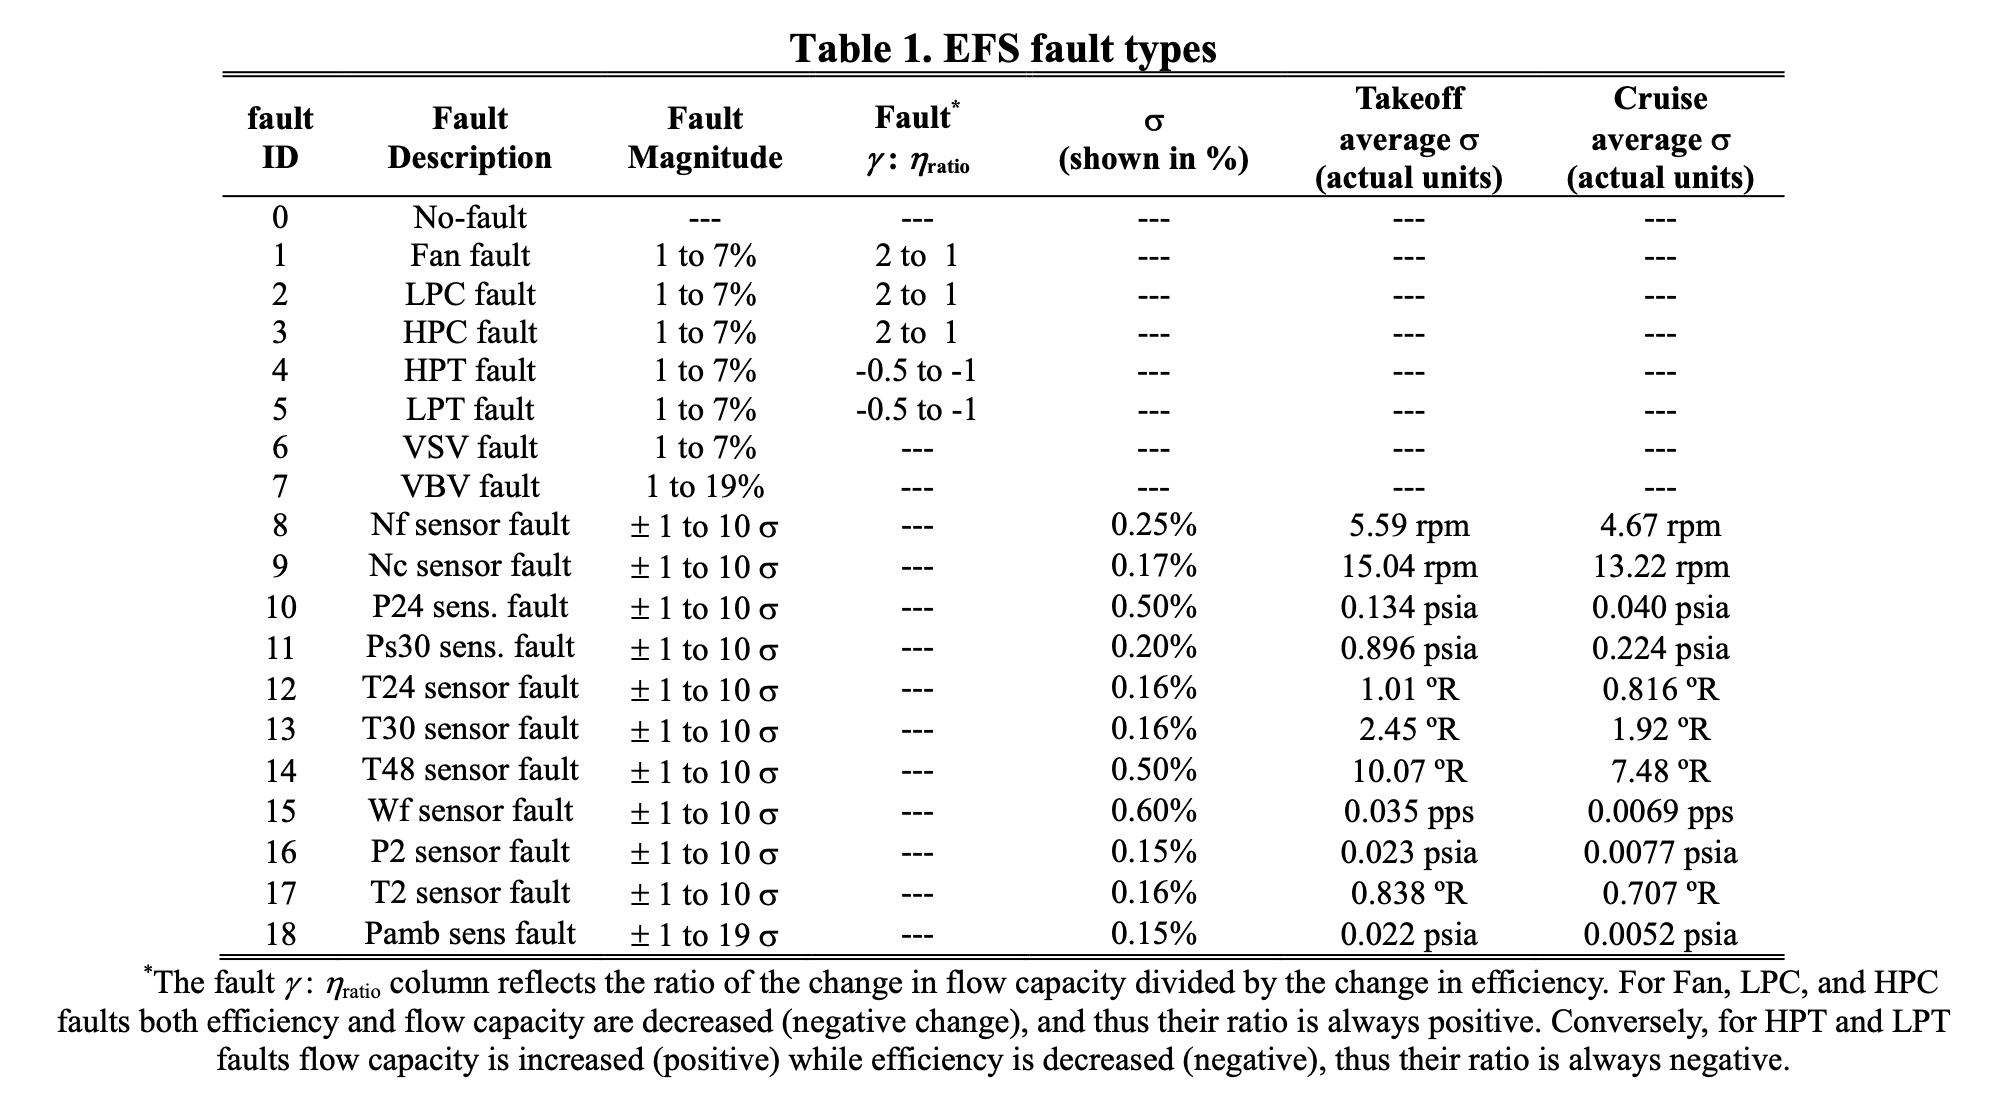

In [114]:
fault_params_df = fault_params_df.rename_axis("engine")

In [115]:
fault_params_df.head()

,fault_id,fligh_initiation,fault_ev_rate,fault_magnitude,fc_eff_ratio
engine,,,,,
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


## Visualize Data

In [116]:
def visualize_param(dataset,engine, ysensor,xsensor):
  y_values = dataset[dataset['engine'] == engine][[ysensor]]
  x_values = dataset[dataset['engine'] == engine][[xsensor]]

  plt.figure(figsize=(8, 6))  # Set the figure size
  plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.xlabel(x_values.columns[0])
  plt.ylabel(y_values.columns[0])
  plt.title(label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.legend()
  plt.grid(True)

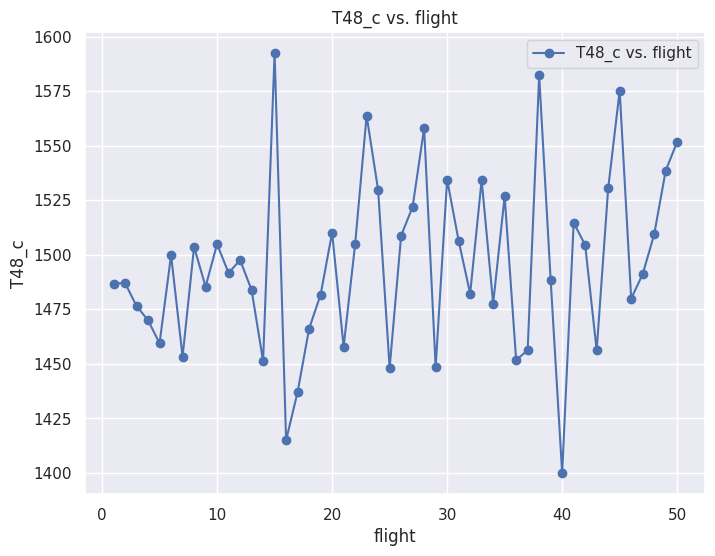

In [117]:
visualize_param(efs_output_c_df,88,"T48_c","flight")

In [118]:
def scatter_values(dataset, engines, ysensor, xsensor, fault_df=fault_params_df):
    fault_df = fault_df.reset_index()

    subset = dataset[dataset['engine'].isin(engines)]

    subset = subset.merge(fault_df[['engine', 'fault_id']], on='engine', how='left')

    fault_ids = subset['fault_id'].unique()
    colors = plt.cm.tab10(range(len(fault_ids)))
    fault_colors = {fault_id: colors[i] for i, fault_id in enumerate(fault_ids)}

    plt.figure(figsize=(10, 7))
    for fault_id, color in fault_colors.items():
        fault_subset = subset[subset['fault_id'] == fault_id]
        plt.scatter(
            fault_subset[xsensor], fault_subset[ysensor],
            color=color, label=f'Fault ID {fault_id}', alpha=0.8
        )

    plt.xlabel(xsensor)
    plt.ylabel(ysensor)
    plt.title(f'{ysensor} vs. {xsensor} by Fault Type')
    plt.legend()
    plt.grid(True)
    plt.show()

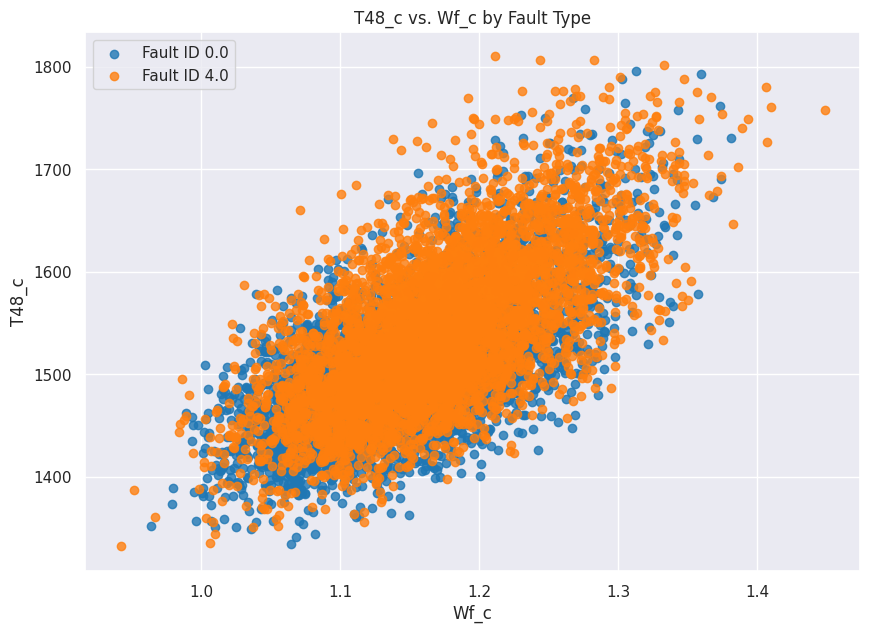

In [119]:
faults = [0,4]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(efs_output_c_df,engines,"T48_c","Wf_c",fault_params_df)

##Data pre-processing

###Baseline

Tentar de dois jeitos:
1. interpolação com dados gerados pelo CMAPSS-SS
2. Rede Neural que faz a estimativa

1. Interpolação com dados gerados pelo CMAPSS-SS

In [120]:
file1 = 'EFS_fault_conditions_health.mat'
file2 = 'EFS_operating_conditions_health.mat'
file3 = 'EFS_Output_health.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path1 = location + file1
file_path2 = location + file2
file_path3 = location + file3

data1 = loadmat(file_path1)
data2 = loadmat(file_path2)
data3 = loadmat(file_path3)

health_efs_output_c = data3['efs_output_c']
health_efs_output_to = data3['efs_output_to']
health_engine_params = data2['engine_params']
health_fault_params = data1['fault_params']
health_sensor_noise = data2['sensor_noise']

In [121]:
health_efs_output_c.shape

(99, 90, 11)

In [122]:
engines, flights, variables = health_efs_output_c.shape

health_efs_output_c_flat = health_efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_c_flat))
health_efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [123]:
engines, flights, variables = health_efs_output_to.shape

health_efs_output_to_flat = health_efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_to_flat))
health_efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [124]:
engines, flights, params = health_engine_params.shape

health_engine_params_flat = health_engine_params.reshape(engines * flights, params)

health_engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, health_engine_params_flat))
health_engine_params_df = pd.DataFrame(data, columns=health_engine_params_columns)

In [125]:
u_to = health_engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_c = health_engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

In [126]:
y_to = health_efs_output_to_df.drop(columns=["engine","flight"])
y_c =  health_efs_output_c_df.drop(columns=["engine","flight"])

In [127]:
y_to.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,2347.975120,9127.818194,26.991351,477.883845,661.264075,1613.168482,2103.313437,6.375072,14.648482,542.684318,14.189660
1,2193.884016,8692.066753,26.499054,453.053558,604.878294,1480.089898,1910.130249,5.571287,15.101387,503.399461,14.664752
2,2344.056446,9070.791867,26.864628,475.382892,656.342616,1598.524555,2098.887880,6.221303,14.509712,535.252087,14.027209
3,2221.627808,8796.517410,26.481335,454.245450,623.864038,1513.257894,1951.795100,5.658897,15.145687,517.121268,14.666531
4,2377.321826,9136.584936,27.040232,474.807499,662.217261,1616.987293,2113.478499,6.347251,14.622191,544.536518,14.187809


In [128]:
models_to = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_to.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_to, y_to[column])

    models_to[column] = pipeline


In [129]:
models_c = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_c.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_c, y_c[column])

    models_c[column] = pipeline

In [130]:
#now estimate for the parameters of the original dataset
u_orig_to = engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c = engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to = {}
for column, model in models_to.items():
    health_y_to[column] = model.predict(u_orig_to)

health_y_c = {}
for column, model in models_c.items():
    health_y_c[column] = model.predict(u_orig_c)

health_y_to_df = pd.DataFrame(health_y_to)
health_y_c_df = pd.DataFrame(health_y_c)

In [131]:
health_y_to_df.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,2334.653212,9084.365859,26.618914,456.368822,657.715814,1609.013968,2139.387094,6.189338,14.530920,540.174397,14.060248
1,2336.889928,9087.982481,27.158973,466.260358,658.474092,1609.446984,2136.775554,6.307579,14.822853,540.806351,14.329518
2,2361.389508,9225.729028,26.580910,454.826469,681.360918,1652.004239,2186.955854,6.233581,14.683809,561.809896,14.226108
3,2325.187510,9009.231241,27.327148,471.580669,645.397499,1585.053751,2108.066451,6.333340,14.791058,528.412394,14.333919
4,2353.609174,9123.105759,26.849808,463.237591,662.822744,1620.145431,2151.679215,6.296660,14.570994,543.537500,14.055876


In [132]:
deviation_to = {}
for column in efs_output_to_df.columns[2:]:
  deviation_to[column] = (efs_output_to_df[column] - health_y_to_df[column])/health_y_to_df[column]

deviation_c = {}
for column in efs_output_c_df.columns[2:]:
  deviation_c[column] = (efs_output_c_df[column] - health_y_c_df[column])/health_y_c_df[column]


deviation_to_df = pd.DataFrame(deviation_to)
deviation_c_df = pd.DataFrame(deviation_c)

In [133]:
deviation_c_df["engine"] = efs_output_c_df["engine"]
deviation_c_df["flight"] = efs_output_c_df["flight"]

In [134]:
deviation_to_df["engine"] = efs_output_to_df["engine"]
deviation_to_df["flight"] = efs_output_to_df["flight"]

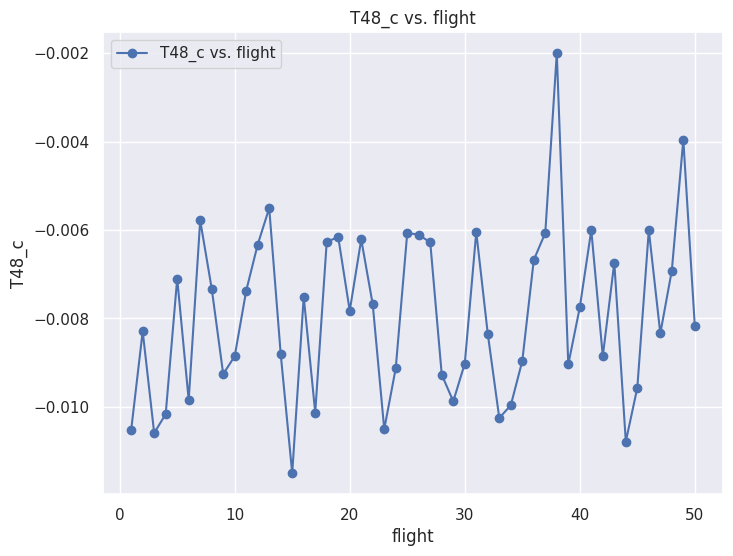

In [135]:
visualize_param(deviation_c_df,88,"T48_c","flight")

In [136]:
#note that for first 10 flights (health engine) deviation is higher than 0.
#Next step is to adjust the general model to consider specific engine characteristics

#first 10 flights are healthy conditions
def calculate_average_deviation(deviation_df):
    average_deviation = (
        deviation_df.groupby('engine')
        .apply(lambda group: group.iloc[:10, :-2].mean())
        .reset_index()
    )
    return average_deviation

average_deviation_to_df = calculate_average_deviation(deviation_to_df)
average_deviation_c_df = calculate_average_deviation(deviation_c_df)

<ipython-input-136-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())
<ipython-input-136-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())


In [137]:
average_deviation_c_df.head()

,engine,Nf_c,Nc_c,P24_c,Ps30_c,T24_c,T30_c,T48_c,Wf_c,P2_c,T2_c,Pamb_c
0,1.0,-0.000982,-0.001121,0.000305,-0.001045,-0.000660,-0.004218,-0.005563,-0.004973,-0.000036,-0.000312,0.000042
1,2.0,0.001248,-0.000629,0.000124,0.005867,0.000313,-0.004062,-0.016317,-0.013421,0.000007,0.000786,0.000054
2,3.0,-0.002517,-0.002068,-0.001840,0.008049,-0.001653,-0.004276,-0.014858,-0.011948,-0.000015,-0.000214,0.000006
3,4.0,0.002917,0.000659,0.002681,-0.005669,0.001637,0.000726,0.007582,0.006840,-0.000014,0.000244,0.000017
4,5.0,0.001682,-0.000558,0.001992,-0.001149,0.001051,0.001577,0.006079,0.004335,0.000005,0.000080,0.000045


In [138]:
health_y_c_df["flight"] = efs_output_c_df["flight"]
health_y_c_df["engine"] = efs_output_c_df["engine"]

health_y_to_df["flight"] = efs_output_to_df["flight"]
health_y_to_df["engine"] = efs_output_to_df["engine"]

In [139]:
def update_health_conditions(health_y_df, avg_deviation_df, deviation_columns):
    updated_health_y_df = health_y_df.copy()

    for engine in avg_deviation_df['engine']:

        engine_avg_deviation = avg_deviation_df[avg_deviation_df['engine'] == engine][deviation_columns].iloc[0]

        engine_mask = (health_y_df['engine'] == engine)
        for column in deviation_columns:
            updated_health_y_df.loc[engine_mask, column] *= (1 + engine_avg_deviation[column])

    return updated_health_y_df

updated_health_y_to_df = update_health_conditions(health_y_to_df, average_deviation_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df = update_health_conditions(health_y_c_df, average_deviation_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)

In [140]:
updated_health_y_to_df.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to,flight,engine
0,2344.771381,9090.857959,26.786920,460.288949,658.810938,1607.406925,2138.635127,6.251169,14.531598,540.155017,14.060297,1.0,1.0
1,2347.017790,9094.477165,27.330388,470.265452,659.570478,1607.839508,2136.024505,6.370591,14.823545,540.786947,14.329568,2.0,1.0
2,2371.623549,9232.322152,26.748677,458.733348,682.495412,1650.354258,2186.187167,6.295854,14.684495,561.789740,14.226158,3.0,1.0
3,2335.264655,9015.669646,27.499625,475.631463,646.472112,1583.470638,2107.325492,6.396609,14.791749,528.393435,14.333969,4.0,1.0
4,2363.809496,9129.625544,27.019271,467.216720,663.926370,1618.527270,2150.922928,6.359563,14.571674,543.517999,14.055926,5.0,1.0


In [141]:
def calculate_final_deviations(observed_df, updated_health_y_df, deviation_columns):
    final_deviation_df = pd.DataFrame()
    for column in deviation_columns:
        final_deviation_df[column] = (observed_df[column] - updated_health_y_df[column]) / updated_health_y_df[column]
    return final_deviation_df

final_deviation_to_df = calculate_final_deviations(efs_output_to_df, updated_health_y_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
final_deviation_c_df = calculate_final_deviations(efs_output_c_df, updated_health_y_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)


In [142]:
final_deviation_to_df["engine"] = efs_output_to_df["engine"]
final_deviation_to_df["flight"] = efs_output_to_df["flight"]

final_deviation_c_df["engine"] = efs_output_c_df["engine"]
final_deviation_c_df["flight"] = efs_output_c_df["flight"]

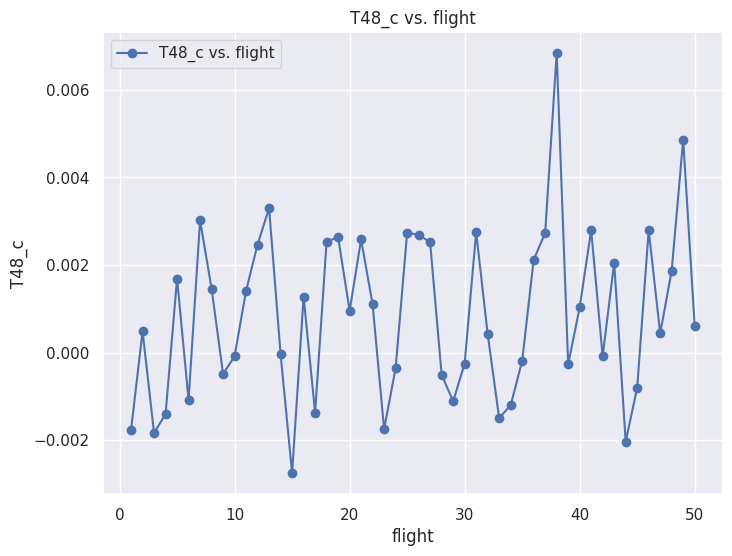

In [143]:
visualize_param(final_deviation_c_df,88,"T48_c","flight")

2. Rede Neural (TBD)

In [144]:
#TBD

###Trend Monitoring

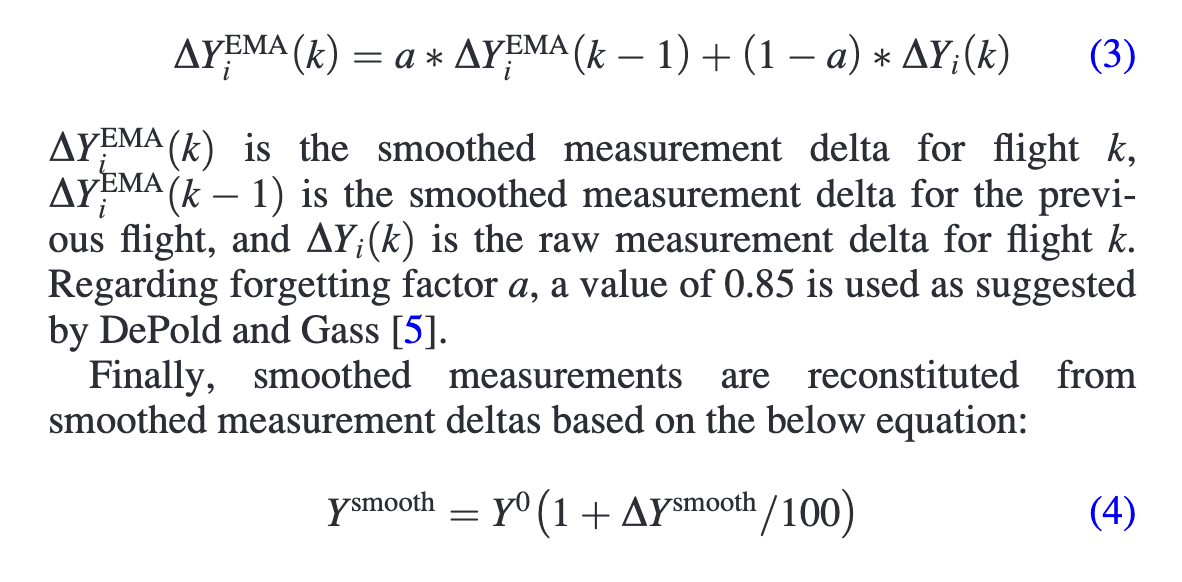

In [145]:
#implement exponential moving average to smooth data
alpha = 0.85 #prodimes user guide uses 0.8844
def apply_exponential_moving_average(df, alpha, deviation_columns):
  ema_data = df[['engine', 'flight']].copy()

  for column in deviation_columns:
      if column not in df.columns:
          raise KeyError(f"Column '{column}' not found in the DataFrame!")

      ema_values = []

      for engine_id in df['engine'].unique():

          engine_data = df[df['engine'] == engine_id]

          if engine_data.empty:
              print(f"Warning: No data found for engine {engine_id}.")
              continue

          ema = engine_data[column].iloc[0]
          ema_values_engine = [ema]

          for k in range(1, len(engine_data)):
              delta_y = engine_data[column].iloc[k]
              ema = alpha * ema + (1 - alpha) * delta_y
              ema_values_engine.append(ema)

          ema_values.extend(ema_values_engine)

      ema_data[f'{column}_ema'] = ema_values

  return ema_data

deviation_columns_to = final_deviation_to_df.drop(columns=['engine', 'flight']).columns

deviation_columns_c = final_deviation_c_df.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df = apply_exponential_moving_average(final_deviation_to_df, alpha, deviation_columns_to)
ema_health_y_c_df = apply_exponential_moving_average(final_deviation_c_df, alpha, deviation_columns_c)

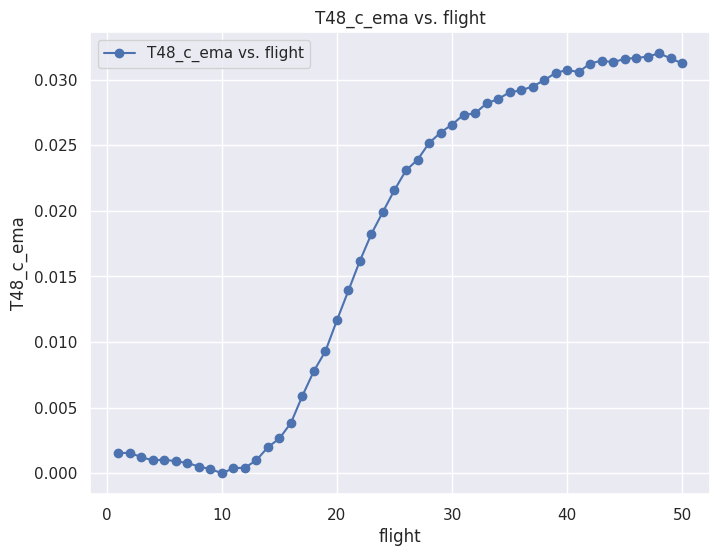

In [146]:
visualize_param(ema_health_y_c_df,378,"T48_c_ema","flight")

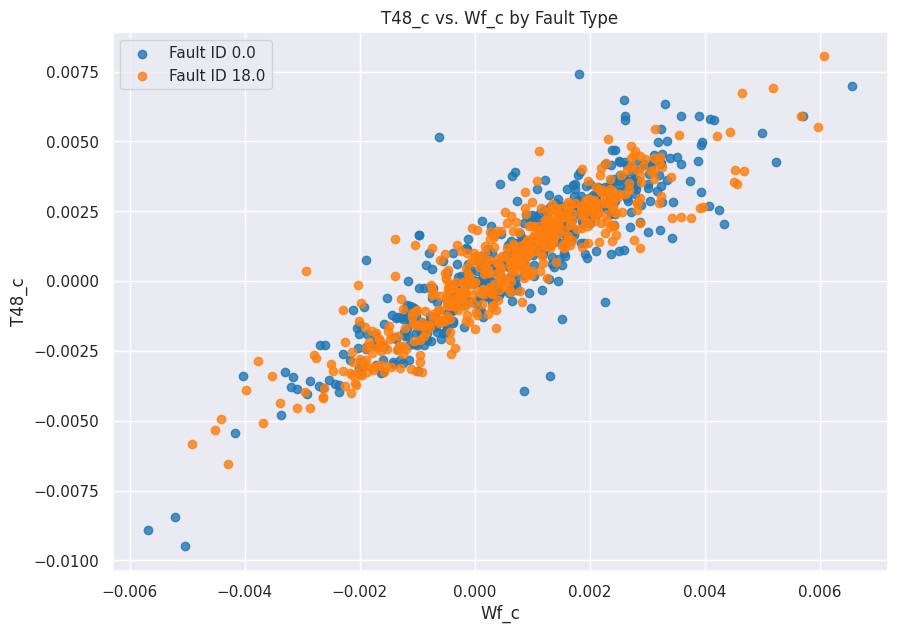

In [147]:
faults = [0,18]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(final_deviation_c_df.query('flight > 45'),engines,"T48_c","Wf_c",fault_params_df)

## Fault Identification & Classification

###Training and validation data treatment

In [148]:
data_total = pd.merge(ema_health_y_to_df, ema_health_y_c_df, on=['engine', 'flight'])

In [149]:
data_total.head()

,engine,flight,Nf_to_ema,Nc_to_ema,P24_to_ema,Ps30_to_ema,T24_to_ema,T30_to_ema,T48_to_ema,Wf_to_ema,...,Nc_c_ema,P24_c_ema,Ps30_c_ema,T24_c_ema,T30_c_ema,T48_c_ema,Wf_c_ema,P2_c_ema,T2_c_ema,Pamb_c_ema
0,1.0,1.0,0.004865,0.001493,0.005813,0.011720,0.001941,0.002165,0.001879,0.012303,...,-0.001179,-0.000351,0.000531,-0.002416,-0.002770,-0.003855,-0.002719,-0.000205,-0.002345,-0.000019
1,1.0,2.0,0.004811,0.001509,0.005795,0.011454,0.001948,0.002271,0.002190,0.012476,...,-0.001130,-0.000365,0.000439,-0.002337,-0.002650,-0.003607,-0.002581,-0.000183,-0.002245,-0.000031
2,1.0,3.0,0.002352,0.000813,0.002558,0.005277,0.000948,0.001200,0.001094,0.005564,...,-0.000911,-0.000280,0.000379,-0.001879,-0.002113,-0.002891,-0.002067,-0.000144,-0.001813,-0.000013
3,1.0,4.0,0.001686,0.000521,0.001766,0.004091,0.000636,0.000651,0.000205,0.003565,...,-0.000697,-0.000218,0.000276,-0.001474,-0.001596,-0.002143,-0.001505,-0.000110,-0.001440,-0.000001
4,1.0,5.0,0.002912,0.000995,0.003619,0.006684,0.001241,0.001592,0.001854,0.007921,...,-0.000517,-0.000191,0.000204,-0.001110,-0.001192,-0.001594,-0.001202,-0.000088,-0.001071,-0.000022


In [150]:
def createlabel(df,fault_param):
  label = {}
  for engine in df['engine'].unique():
    if engine not in fault_param.index:
      print(f"Warning: Engine {engine} not found in fault_param. Skipping.")
      continue  # Skip engines that are not in fault_param
    flight_init = fault_param.loc[engine]['fligh_initiation']
    fault_id = fault_param.loc[engine]['fault_id']

    for flight in df[df['engine'] == engine]['flight']:
      if flight < flight_init:
        label[(engine,flight)] = 0
      else:
        label[(engine,flight)] = fault_id
  return label


In [151]:
fault_label = createlabel(data_total,fault_params_df)

In [152]:
fault_label_df = (
    pd.DataFrame.from_dict(fault_label, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df[['engine', 'flight']] = pd.DataFrame(fault_label_df['index'].tolist(), index=fault_label_df.index)
fault_label_df = fault_label_df.drop(columns=['index'])

data_total_with_labels = pd.merge(data_total, fault_label_df, on=['engine', 'flight'], how='left')

In [153]:
data_total_with_labels.head()

,engine,flight,Nf_to_ema,Nc_to_ema,P24_to_ema,Ps30_to_ema,T24_to_ema,T30_to_ema,T48_to_ema,Wf_to_ema,...,P24_c_ema,Ps30_c_ema,T24_c_ema,T30_c_ema,T48_c_ema,Wf_c_ema,P2_c_ema,T2_c_ema,Pamb_c_ema,fault_label
0,1.0,1.0,0.004865,0.001493,0.005813,0.011720,0.001941,0.002165,0.001879,0.012303,...,-0.000351,0.000531,-0.002416,-0.002770,-0.003855,-0.002719,-0.000205,-0.002345,-0.000019,0.0
1,1.0,2.0,0.004811,0.001509,0.005795,0.011454,0.001948,0.002271,0.002190,0.012476,...,-0.000365,0.000439,-0.002337,-0.002650,-0.003607,-0.002581,-0.000183,-0.002245,-0.000031,0.0
2,1.0,3.0,0.002352,0.000813,0.002558,0.005277,0.000948,0.001200,0.001094,0.005564,...,-0.000280,0.000379,-0.001879,-0.002113,-0.002891,-0.002067,-0.000144,-0.001813,-0.000013,0.0
3,1.0,4.0,0.001686,0.000521,0.001766,0.004091,0.000636,0.000651,0.000205,0.003565,...,-0.000218,0.000276,-0.001474,-0.001596,-0.002143,-0.001505,-0.000110,-0.001440,-0.000001,0.0
4,1.0,5.0,0.002912,0.000995,0.003619,0.006684,0.001241,0.001592,0.001854,0.007921,...,-0.000191,0.000204,-0.001110,-0.001192,-0.001594,-0.001202,-0.000088,-0.001071,-0.000022,0.0


In [154]:
data_total_with_labels = data_total_with_labels.dropna(subset=['fault_label'])

In [155]:
X = data_total_with_labels.drop(columns=['engine', 'flight', 'fault_label'])
y = data_total_with_labels['fault_label']

#in the future it will be better to make a subset of full flights for each engine for all fault scenarios

In [156]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (75840, 22)
X_test shape :  (18960, 22)
y_train shape :  (75840,)
y_test shape :  (18960,)


In [192]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Classification Algorithms

In [193]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

num_classes = len(y_train.unique())
if num_classes > 2:  # Multiclass classification
    y_train_encoded = to_categorical(y_train, num_classes=num_classes)
    y_test_encoded = to_categorical(y_test, num_classes=num_classes)
else:
    y_train_encoded = y_train
    y_test_encoded = y_test

# Define the neural network
model_ANN = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')  # Output layer
])

# Compile the model
model_ANN.compile(
    optimizer='adam',
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_ANN.fit(
    X_train, y_train_encoded,
    epochs=50,  # Adjust epochs as needed
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model_ANN.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6455 - loss: 1.5153 - val_accuracy: 0.7881 - val_loss: 0.8951
Epoch 2/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7702 - loss: 0.9408 - val_accuracy: 0.8014 - val_loss: 0.8312
Epoch 3/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7848 - loss: 0.8867 - val_accuracy: 0.8074 - val_loss: 0.8054
Epoch 4/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7934 - loss: 0.8649 - val_accuracy: 0.8095 - val_loss: 0.7898
Epoch 5/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7996 - loss: 0.8403 - val_accuracy: 0.8100 - val_loss: 0.7835
Epoch 6/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7989 - loss: 0.8422 - val_accuracy: 0.8104 - val_loss: 0.7727
Epoch 7/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8003 - loss: 0.8332 - val_accuracy: 0.8113 - val_loss: 0.7655
Epoch 8/50
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8026 - loss: 0.8236

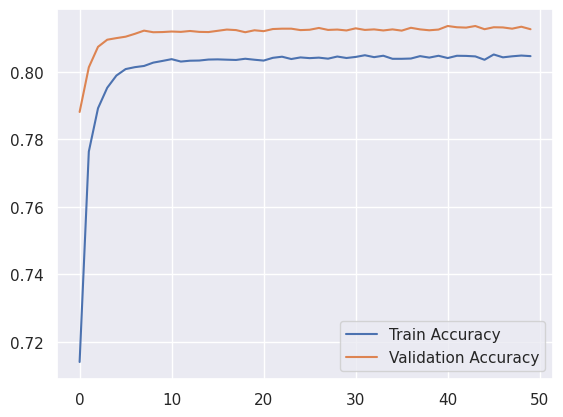

In [194]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


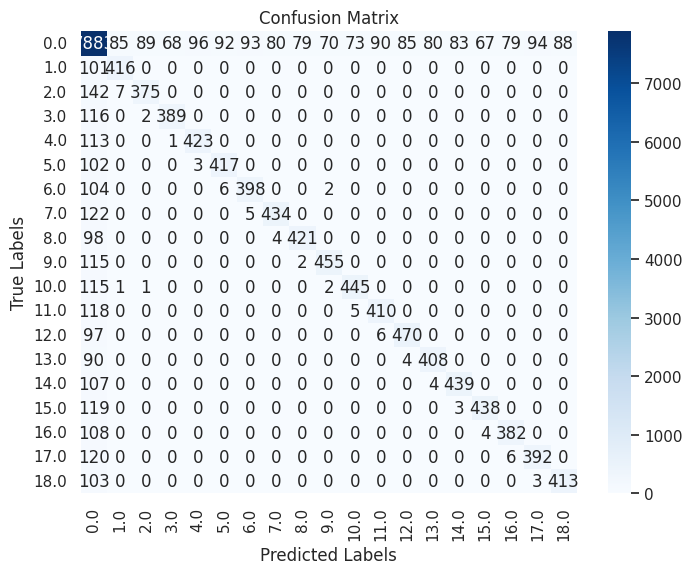

In [195]:
y_pred = model_ANN.predict(X_test)

y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [198]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import StandardScaler

X_train_array = X_train
X_test_array = X_test

X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

#one hot encode
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Define the CNN model
model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
])

# Compile the model
model_CNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_CNN.fit(
    X_train_reshaped, y_train_encoded,
    epochs=30,  # Adjust epochs as needed
    batch_size=32,
    validation_data=(X_test_reshaped, y_test_encoded),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model_CNN.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2370/2370 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.7178 - loss: 1.1939 - val_accuracy: 0.7983 - val_loss: 0.8351
Epoch 2/30
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7934 - loss: 0.8675 - val_accuracy: 0.8027 - val_loss: 0.8039
Epoch 3/30
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.7994 - loss: 0.8257 - val_accuracy: 0.8044 - val_loss: 0.7781
Epoch 4/30
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7997 - loss: 0.8191 - val_accuracy: 0.8066 - val_loss: 0.7699
Epoch 5/30
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8043 - loss: 0.7960 - val_accuracy: 0.8073 - val_loss: 0.7631
Epoch 6/30
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8061 - loss: 0.7824 - val_accuracy: 0.8097 - val_loss: 0.7497
Epoch 7/30
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8079 - loss: 0.7681 - val_accuracy: 0.8107 - val_loss: 0.7388
Epoch 8/30
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8080 - loss: 0.7562 - va

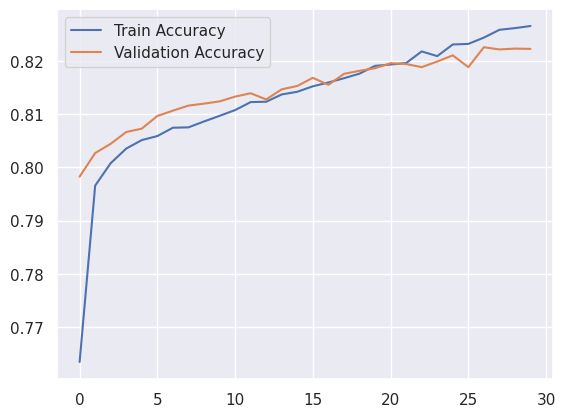

In [201]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


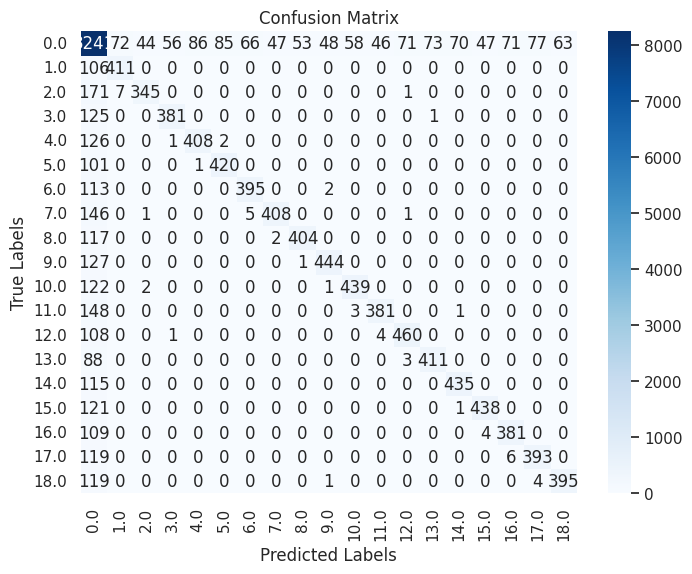

In [202]:
y_pred = model_CNN.predict(X_test)

y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [203]:
y_pred

array([[7.4955016e-01, 5.5406154e-03, 6.0149576e-03, ..., 9.0323025e-03,
        2.6394716e-02, 2.8284678e-02],
       [5.8091170e-01, 4.2984495e-03, 1.5148957e-03, ..., 5.0876099e-03,
        2.5486428e-02, 2.6310530e-02],
       [9.9090493e-01, 1.0813503e-07, 5.1193521e-05, ..., 8.5091833e-06,
        5.8733134e-05, 5.0966395e-03],
       ...,
       [1.0966826e-01, 1.5943426e-04, 8.7126673e-06, ..., 1.1920620e-11,
        5.3790922e-07, 3.5863347e-11],
       [1.3787611e-02, 2.2473834e-14, 2.0092909e-15, ..., 3.4310753e-14,
        1.2314357e-15, 2.7929355e-15],
       [2.2972363e-01, 1.5683256e-09, 5.3428654e-13, ..., 5.2654588e-07,
        7.8170777e-09, 7.8803525e-10]], dtype=float32)

## Testing with new data for evaluation

In [204]:
filename = 'data_evaluation.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

data_eval = loadmat(file_path)

efs_output_c_eval = data_eval['efs_output_c']
efs_output_to_eval = data_eval['efs_output_to']
engine_params_eval = data_eval['engine_params']
fault_params_eval = data_eval['fault_params']
sensor_noise_eval = data_eval['sensor_noise']

engines, flights, variables = efs_output_c_eval.shape

efs_output_c_flat_eval = efs_output_c_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_c_flat_eval))
efs_output_c_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [205]:
engines, flights, variables = efs_output_to_eval.shape

efs_output_to_flat_eval = efs_output_to_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_to_flat_eval))
efs_output_to_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [206]:
engines, flights, params = engine_params_eval.shape

engine_params_flat_eval = engine_params_eval.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, engine_params_flat_eval))
engine_params_df_eval = pd.DataFrame(data_eval, columns=engine_params_columns)

In [207]:
fault_params_df_eval = pd.DataFrame(fault_params_eval, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

In [208]:
fault_params_df_eval = fault_params_df_eval.rename_axis("engine")

In [209]:
u_orig_to_eval = engine_params_df_eval[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c_eval = engine_params_df_eval[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to_eval = {}
for column, model_health in models_to.items():
    health_y_to_eval[column] = model_health.predict(u_orig_to_eval)

health_y_c_eval = {}
for column, model_health in models_c.items():
    health_y_c_eval[column] = model_health.predict(u_orig_c_eval)

health_y_to_df_eval = pd.DataFrame(health_y_to_eval)
health_y_c_df_eval = pd.DataFrame(health_y_c_eval)

In [210]:
deviation_to_eval = {}
for column in efs_output_to_df_eval.columns[2:]:
  deviation_to_eval[column] = (efs_output_to_df_eval[column] - health_y_to_df_eval[column])/health_y_to_df_eval[column]

deviation_c_eval = {}
for column in efs_output_c_df_eval.columns[2:]:
  deviation_c_eval[column] = (efs_output_c_df_eval[column] - health_y_c_df_eval[column])/health_y_c_df_eval[column]


deviation_to_df_eval = pd.DataFrame(deviation_to_eval)
deviation_c_df_eval = pd.DataFrame(deviation_c_eval)

In [211]:
deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

In [212]:
average_deviation_to_df_eval = calculate_average_deviation(deviation_to_df_eval)
average_deviation_c_df_eval = calculate_average_deviation(deviation_c_df_eval)

<ipython-input-136-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())
<ipython-input-136-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())


In [213]:
health_y_c_df_eval["flight"] = efs_output_c_df_eval["flight"]
health_y_c_df_eval["engine"] = efs_output_c_df_eval["engine"]

health_y_to_df_eval["flight"] = efs_output_to_df_eval["flight"]
health_y_to_df_eval["engine"] = efs_output_to_df_eval["engine"]

In [214]:
updated_health_y_to_df_eval = update_health_conditions(health_y_to_df_eval, average_deviation_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df_eval = update_health_conditions(health_y_c_df_eval, average_deviation_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [215]:
final_deviation_to_df_eval = calculate_final_deviations(efs_output_to_df_eval, updated_health_y_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
final_deviation_c_df_eval = calculate_final_deviations(efs_output_c_df_eval, updated_health_y_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [216]:
final_deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
final_deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

final_deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
final_deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

In [217]:
deviation_columns_to_eval = final_deviation_to_df_eval.drop(columns=['engine', 'flight']).columns

deviation_columns_c_eval = final_deviation_c_df_eval.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df_eval = apply_exponential_moving_average(final_deviation_to_df_eval, alpha, deviation_columns_to_eval)
ema_health_y_c_df_eval = apply_exponential_moving_average(final_deviation_c_df_eval, alpha, deviation_columns_c_eval)

In [218]:
data_total_eval = pd.merge(ema_health_y_to_df_eval, ema_health_y_c_df_eval, on=['engine', 'flight'])

In [219]:
fault_label_eval = createlabel(data_total_eval,fault_params_df_eval)

In [220]:
fault_label_df_eval = (
    pd.DataFrame.from_dict(fault_label_eval, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df_eval[['engine', 'flight']] = pd.DataFrame(fault_label_df_eval['index'].tolist(), index=fault_label_df_eval.index)
fault_label_df_eval = fault_label_df_eval.drop(columns=['index'])

data_total_with_labels_eval = pd.merge(data_total_eval, fault_label_df_eval, on=['engine', 'flight'], how='left')

In [221]:
data_total_with_labels_eval = data_total_with_labels_eval.dropna(subset=['fault_label'])

In [222]:
X_eval = data_total_with_labels_eval.drop(columns=['engine', 'flight', 'fault_label'])
y_eval = data_total_with_labels_eval['fault_label']

In [223]:
#X_eval_array = X_eval.values
X_eval = scaler.transform(X_eval)
#X_eval_reshaped = X_eval_array.reshape(X_eval_array.shape[0], X_eval_array.shape[1], 1)

888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


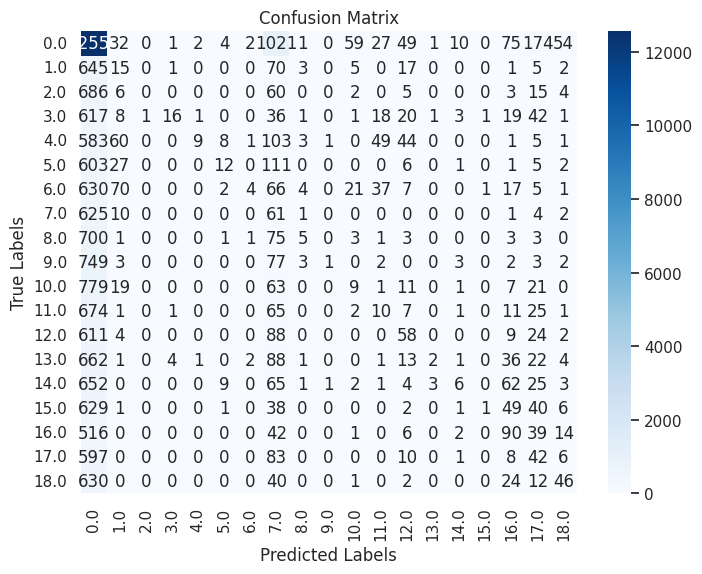

In [224]:
y_pred_eval = model_CNN.predict(X_eval)

y_pred_labels_eval = y_pred_eval.argmax(axis=1)

cm = confusion_matrix(y_eval, y_pred_labels_eval)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Diagnostic Matrix

In [186]:
def create_diagnostic_matrix(engines, flights, y_predicted):
    engines = engines.astype(int)
    flights = flights.astype(int)

    num_engines = len(set(engines))
    num_flights = flights.max()

    y_pred_labels = np.argmax(y_predicted, axis=1)

    diagnostic_matrix = diagnostic_matrix = y_pred_labels.reshape(num_engines, num_flights)

    return diagnostic_matrix

In [187]:
diagnostic_matrix = create_diagnostic_matrix(
    data_total_with_labels_eval["engine"],
    data_total_with_labels_eval["flight"],
    y_pred_eval
)

In [188]:
diagnostic_matrix[378]

array([18,  0,  0,  0,  0,  0,  0, 18, 18,  0, 18, 18, 18, 18,  0, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18])

In [189]:
from scipy.io import savemat

# Data to save
data_to_save = {'diagnostic_matrix': diagnostic_matrix}

# Save to .mat file
savemat('diagnostic_matrix.mat', data_to_save)

print("Diagnostic matrix saved to diagnostic_matrix.mat")

Diagnostic matrix saved to diagnostic_matrix.mat


## Evaluation

In [190]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score


diagnostic_assessment = diagnostic_matrix


num_engines = len(data_total_with_labels_eval["engine"].astype(int))
num_flights = diagnostic_assessment.shape[1]  # Number of flights per engine
# Fault magnitude thresholds (small, medium, large)
sml_fault_mag = np.array([
    [3, 5],   # Fan (%)
    [3, 5],   # LPC (%)
    [3, 5],   # HPC (%)
    [3, 5],   # HPT (%)
    [3, 5],   # LPT (%)
    [3, 5],   # VSV (%)
    [7, 13],  # VBV (%)
    [4, 7],   # Nf (sigma)
    [4, 7],   # Nc (sigma)
    [4, 7],   # P24 (sigma)
    [4, 7],   # Ps30 (sigma)
    [4, 7],   # T24 (sigma)
    [4, 7],   # T30 (sigma)
    [4, 7],   # T48 (sigma)
    [4, 7],   # Wf36 (sigma)
    [4, 7],   # P2 (sigma)
    [4, 7],   # T2 (sigma)
    [7, 13]   # Pamb (sigma)
])

# Parameters
start_flight = 11
abrupt_window = 10
rapid_window = 6

# Initialize confusion matrices and counters
confusion_matrix_all = np.zeros((19, 19, 2, 3))  # True condition x Diagnosed condition x Evolution x Magnitude
confusion_matrix_no_fault = np.zeros((1, 19))  # For "No Fault" cases

tp_latency = np.zeros((19, 2, 3))
cc_latency = np.zeros((19, 2, 3))
tp_counter = np.zeros((19, 2, 3))
cc_counter = np.zeros((19, 2, 3))

# Ensure num_engines is correctly aligned with diagnostic_assessment
num_engines = diagnostic_assessment.shape[0]  # Match the first dimension of diagnostic_assessment

for i in range(num_engines):  # Iterate over valid engine indices
    true_fault_type = int(fault_params_df_eval.iloc[i, 0])
    fault_start = int(fault_params_df_eval.iloc[i, 1])
    fault_evolution = int(fault_params_df_eval.iloc[i, 2])
    fault_magnitude = fault_params_df_eval.iloc[i, 3]

    # 1. No Fault cases
    if true_fault_type == 0:
        for flight in range(start_flight, min(num_flights, fault_start)):
            diagnosed_fault = diagnostic_assessment[i, flight]
            column = 19 if diagnosed_fault == 0 else diagnosed_fault
            confusion_matrix_no_fault[0, column - 1] += 1

    # 2. Fault cases
    else:
        if fault_evolution == 0:  # Abrupt
            evolution_flag = 0
            diagnostic_window = range(fault_start, min(fault_start + abrupt_window, num_flights))
        else:  # Rapid
            evolution_flag = 1
            diagnostic_window = range(fault_start, min(fault_start + fault_evolution + rapid_window, num_flights))

        if abs(fault_magnitude) < sml_fault_mag[int(true_fault_type) - 1, 0]:
            magnitude_flag = 0  # Small
        elif abs(fault_magnitude) > sml_fault_mag[int(true_fault_type) - 1, 1]:
            magnitude_flag = 2  # Large
        else:
            magnitude_flag = 1  # Medium

        for flight in diagnostic_window:
            diagnosed_fault = diagnostic_assessment[i, flight]
            column = 19 if diagnosed_fault == 0 else diagnosed_fault
            confusion_matrix_all[int(true_fault_type) - 1, column - 1, evolution_flag, magnitude_flag] += 1

            if diagnosed_fault != 0:  # True positive
                tp_counter[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += 1
                tp_latency[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += flight - fault_start

                if diagnosed_fault == true_fault_type:  # Correct classification
                    cc_counter[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += 1
                    cc_latency[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += flight - fault_start

confusion_matrix_abrupt = confusion_matrix_all[:, :, 0, :].sum(axis=2)
confusion_matrix_rapid = confusion_matrix_all[:, :, 1, :].sum(axis=2)

# Kappa Coefficients
def calculate_kappa(matrix):
    total = np.sum(matrix)
    observed_agreement = np.trace(matrix)
    expected_agreement = sum((np.sum(matrix, axis=0) * np.sum(matrix, axis=1)) / total)
    return (observed_agreement - expected_agreement) / (total - expected_agreement)

kappa_abrupt = calculate_kappa(confusion_matrix_abrupt)
kappa_rapid = calculate_kappa(confusion_matrix_rapid)

# Normalize Confusion Matrices
confusion_matrix_abrupt_normalized = np.zeros_like(confusion_matrix_abrupt, dtype=float)
confusion_matrix_rapid_normalized = np.zeros_like(confusion_matrix_rapid, dtype=float)

for i in range(confusion_matrix_abrupt.shape[0]):
    row_sum_abrupt = confusion_matrix_abrupt[i].sum()
    row_sum_rapid = confusion_matrix_rapid[i].sum()

    if row_sum_abrupt > 0:
        confusion_matrix_abrupt_normalized[i] = confusion_matrix_abrupt[i] / row_sum_abrupt
    else:
        confusion_matrix_abrupt_normalized[i] = np.nan  # Handle zero row

    if row_sum_rapid > 0:
        confusion_matrix_rapid_normalized[i] = confusion_matrix_rapid[i] / row_sum_rapid
    else:
        confusion_matrix_rapid_normalized[i] = np.nan  # Handle zero row
print("Kappa Coefficient (Abrupt):", kappa_abrupt)
print("Kappa Coefficient (Rapid):", kappa_rapid)

Kappa Coefficient (Abrupt): 0.14652745892039426
Kappa Coefficient (Rapid): 0.07885852764475783
